# 示例：自定义实验配置及回调机制
本示例在故障诊断示例基础上增加自定义配置功能

In [1]:
import torch
from torch import nn

from fastphm.data import Dataset
from fastphm.data.FeatureExtractor import FeatureExtractor
from fastphm.data.labeler.BearingFaultLabeler import BearingFaultLabeler
from fastphm.data.loader.bearing.XJTULoader import XJTULoader
from fastphm.data.processor.RMSProcessor import RMSProcessor
from fastphm.entity.Bearing import Fault
from fastphm.metric.Evaluator import Evaluator
from fastphm.metric.end2end.Accuracy import Accuracy
from fastphm.metric.end2end.WeightedF1Score import WeightedF1Score
from fastphm.data.stage.BearingStageCalculator import BearingStageCalculator
from fastphm.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from fastphm.model.pytorch.base.BaseTester import BaseTester
from fastphm.model.pytorch.base.BaseTrainer import BaseTrainer
from fastphm.model.pytorch.basic.CNN import CNN
from fastphm.util.Plotter import Plotter
from fastphm.model.pytorch.callback.CheckGradientsCallback import CheckGradientsCallback
from fastphm.model.pytorch.callback.EarlyStoppingCallback import EarlyStoppingCallback
from fastphm.model.pytorch.callback.TensorBoardCallback import TensorBoardCallback

### 定义 数据加载器、特征提取器、fpt计算器

In [2]:
data_loader = XJTULoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = FeatureExtractor(RMSProcessor(data_loader.continuum))
fpt_calculator = ThreeSigmaFPTCalculator()
stage_calculator = BearingStageCalculator(data_loader.continuum, fpt_calculator)
Plotter.DPI = 80

[DEBUG   15:11:23]  
[DataLoader]  Root directory: D:\data\dataset\XJTU-SY_Bearing_Datasets
	✓ Bearing1_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
	✓ Bearing1_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
	✓ Bearing1_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
	✓ Bearing1_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
	✓ Bearing1_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
	✓ Bearing2_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
	✓ Bearing2_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
	✓ Bearing2_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
	✓ Bearing2_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
	✓ Bearing2_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
	✓ Bearing3_1, location: D:\data\datas

### 构造数据集

In [3]:
fault_types = [Fault.NC, Fault.OF, Fault.IF, Fault.CF]
labeler = BearingFaultLabeler(2048, fault_types, is_multi_hot=False)
dataset = Dataset()
for bearing_name in ['Bearing1_1', 'Bearing1_2', 'Bearing1_4', 'Bearing2_1', 'Bearing2_3']:
    bearing = data_loader(bearing_name, 'Horizontal Vibration')
    feature_extractor(bearing)
    stage_calculator(bearing)
    dataset.add(labeler(bearing))

[INFO    15:11:23]  [DataLoader]  -> Loading data entity: Bearing1_1
[INFO    15:11:25]  [DataLoader]  ✓ Successfully loaded: Bearing1_1
[INFO    15:11:25]  [DataLoader]  -> Loading data entity: Bearing1_2
[INFO    15:11:29]  [DataLoader]  ✓ Successfully loaded: Bearing1_2
[INFO    15:11:29]  [DataLoader]  -> Loading data entity: Bearing1_4
[INFO    15:11:31]  [DataLoader]  ✓ Successfully loaded: Bearing1_4
[INFO    15:11:31]  [DataLoader]  -> Loading data entity: Bearing2_1
[INFO    15:11:40]  [DataLoader]  ✓ Successfully loaded: Bearing2_1
[INFO    15:11:40]  [DataLoader]  -> Loading data entity: Bearing2_3
[INFO    15:11:51]  [DataLoader]  ✓ Successfully loaded: Bearing2_3


### 划分数据集：训练集（70%）、验证集（15%）、测试集（15%）
- 训练集：用于模型参数学习
- 验证集：用于模型调参、早停（early stopping）、选择最佳模型
- 测试集：只用于最终性能评估，不参与任何训练和调参过程

In [4]:
train_set, test_set = dataset.split_by_ratio(0.7)
val_set, test_set = test_set.split_by_ratio(0.5)

### 配置测试算法
因为没有什么可设置的参数，其实可以使用默认配置。这里使用自定义配置仅为示例

In [5]:
test_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dtype': torch.float32,
}
tester = BaseTester(test_config)

### 自定义配置训练算法&早停、tensorboard、梯度检测回调
- EarlyStoppingCallback，早停回调，耐心10，使用准确率指标选取最佳模型
- TensorBoardCallback，自动将模型参数保存至tensorboard，文件保存至runs文件夹下
- CheckGradientsCallback，检查模型梯度，当过大（梯度爆炸），过小（梯度消失）时日志记录警告信息

In [6]:
train_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dtype': torch.float32,
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.01,
    'weight_decay': 0.0,
    'criterion': nn.CrossEntropyLoss(),
    'callbacks': [
        EarlyStoppingCallback(patience=10,
                              val_set=val_set,
                              metric=Accuracy(),
                              tester=tester),
        TensorBoardCallback(),
        CheckGradientsCallback()
    ]
}
trainer = BaseTrainer(train_config)

### 定义模型并训练

In [7]:
model = CNN(2048, len(fault_types))
losses = trainer.train(model, train_set)

[INFO    15:11:51]  
[Trainer]  Start training by BaseTrainer:
	training set: Bearing1_1; Bearing1_2; Bearing1_4;…
	device: cuda
	dtype: torch.float32
	epochs: 100
	batch_size: 128
	lr: 0.01
	weight_decay: 0.0
	criterion: CrossEntropyLoss()
	callbacks: [EarlyStoppingCallback, TensorBoardCallback, CheckGradientsCallback]
	optimizer: Adam
[DEBUG   15:11:52]  [EarlyStopping]  On the validation set Bearing1_1; Bearing1_2; Bearing1_4; Bearing2_1; Bearing2_3, the Accuracy is 0.1618
[INFO    15:11:52]  [BaseTrainer]  Epoch [1/100], CrossEntropyLoss:0.2765
[DEBUG   15:11:52]  [EarlyStopping]  On the validation set Bearing1_1; Bearing1_2; Bearing1_4; Bearing2_1; Bearing2_3, the Accuracy is 0.9542
[WARNING 15:11:52]  [CheckGradients]  se2.excitation.0.weight gradient is very small: 0.00e+00
[WARNING 15:11:52]  [CheckGradients]  se2.excitation.0.bias gradient is very small: 0.00e+00
[WARNING 15:11:52]  [CheckGradients]  se2.excitation.2.weight gradient is very small: 0.00e+00
[INFO    15:11:53]  

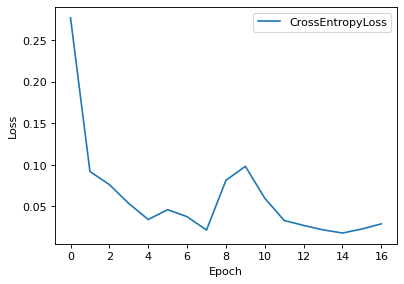

In [8]:
Plotter.loss(losses)

### 预测

In [9]:
result = tester.test(model, test_set)

### 预测结果评估

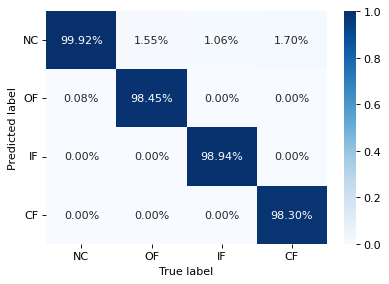

In [10]:
Plotter.confusion_matrix(test_set, result, types=fault_types)

In [11]:
evaluator = Evaluator()
evaluator.add(Accuracy(), WeightedF1Score())
evaluator(test_set, result)

[INFO    15:12:00]  
[Evaluator]  Performance Evaluation:
             Accuracy WeightedF1Score
Bearing1_1     0.9831          0.9831
Bearing1_2     0.9922          0.9923
Bearing1_4     0.9829          0.9791
Bearing2_1     0.9992          0.9991
Bearing2_3     0.9969          0.9969
mean(global)   0.9948          0.9947
mean(group)    0.9948          0.9944



,Accuracy,WeightedF1Score
Bearing1_1,0.9831,0.9831
Bearing1_2,0.9922,0.9923
Bearing1_4,0.9829,0.9791
Bearing2_1,0.9992,0.9991
Bearing2_3,0.9969,0.9969
mean(global),0.9948,0.9947
mean(group),0.9948,0.9944
